In [1]:
import json
import pandas as pd
import woodwork as ww
import tqdm
import numpy as np
from sklearn.cluster import KMeans

/Users/max2/.pyenv/versions/3.10.1/envs/marathon/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
with open('data/runners_with_data.json', 'r') as fp:
    data = json.load(fp)

In [3]:
def time_to_seconds(time):
    if pd.isna(time) or time == "–":
        return None
    hour, minutes, seconds = time.split(":")
    return int(hour)*60*60 + int(minutes)*60 + int(seconds)

def zero_pad(num):
    num_str = "0" + str(num)
    return num_str[-2:]

def seconds_to_time(seconds):
    hours = int(seconds / (60*60))
    minutes = int((seconds - hours*(60*60)) / 60)
    secs = int(seconds - hours*(60*60) - minutes*60) 
    return "{hours}:{minutes}:{seconds}".format(hours=zero_pad(hours), minutes=zero_pad(minutes), seconds=zero_pad(secs))

In [4]:
# data for animation
animate_data = []
for d in data:
    add = {
        0: time_to_seconds("00:00:00"),
        5: time_to_seconds(d['splits']["5km"]["time"]),
        10: time_to_seconds(d['splits']["10km"]["time"]),
        15: time_to_seconds(d['splits']["15km"]["time"]),
        20: time_to_seconds(d['splits']["20km"]["time"]),
        21.0975: time_to_seconds(d['splits']["half"]["time"]),
        25: time_to_seconds(d['splits']["25km"]["time"]),
        30: time_to_seconds(d['splits']["30km"]["time"]),
        35: time_to_seconds(d['splits']["35km"]["time"]),
        40: time_to_seconds(d['splits']["40km"]["time"]),
        42.195: time_to_seconds(d['splits']["finish"]["time"]),
    }
    
    animate_data.append(add)
    
with open('data/animate_runners.json', 'w') as fp:
    json.dump(animate_data, fp)

In [149]:
df = pd.DataFrame(pd.json_normalize(data))

to_drop = ["details_url", "bib", "city_state", "finish_time", "half_time", "name"] 
# drop time of day for now
to_drop += [c for c in df.columns if "time_of_day" in c]
df = df.drop(columns=to_drop)

# handle missing value marker
df = df.replace("–", np.nan)


# convert to seconds to make easier to work with
time_cols = [c for c in df.columns if ".time" in c]
df[time_cols] = df[time_cols].applymap(time_to_seconds)

# rename to remove leading "split"
df = df.rename(columns=dict([(c, c[7:]) for c in time_cols])).rename(columns={"start.time": "0km.time"})

# drop row with missing splits for now
df = df.dropna(axis=0)


# calculate pace

df["finish_pace"] = (df["finish.time"] / 26.2).astype(int)
df["half_pace"] = (df["half.time"] / 13.1).astype(int)


splits = [5, 10, 15, 20, 25, 30, 35, 40]
def splits_list(df):
    l = []
    for s in splits:
        five_km_to_miles = 3.10686
        mile_pace = int((df[str(s) + "km.time"] - df[str(s-5) + "km.time"]) / five_km_to_miles)
        l.append(mile_pace)
    return l
df["5km_split_pace"] = df.apply(splits_list, axis=1)

df["mean_split_pace"] = df["5km_split_pace"].apply(np.mean).astype(int)
df["mean_split_pace_norm"] = df["mean_split_pace"] / df["finish.time"]

df["std_split_pace"] = df["5km_split_pace"].apply(np.std).astype(int)
df["std_split_pace_norm"] = df["std_split_pace"]/df["mean_split_pace"]


# hit_wall_ratio
def hit_wall_ratio(s):
    return s[-1] / np.mean(s[:-1])
df['hit_wall_ratio'] = df["5km_split_pace"].apply(hit_wall_ratio)


# max split difference 
def max_split_diff(s):
    return np.max(s) - np.min(s)
df['max_split_diff'] = df["5km_split_pace"].apply(max_split_diff)

# What is a reasonable target time?

What is the typical time by age group? 

25-34 year olds all seem to run about the same, so I should compare myselfs to them

In [152]:
# average time and 
df_stats = df.groupby("age_class")["finish.time"].agg(["count", "mean", "median", "std"])
df_stats["mean_pace"] = (df_stats["mean"] / 26.2).apply(seconds_to_time)
df_stats["mean"] = df_stats["mean"].apply(seconds_to_time)
df_stats["median"] = df_stats["median"].apply(seconds_to_time)
df_stats["std"] = df_stats["std"].apply(seconds_to_time)
df_stats["mean_hit_wall_ratio"] = df.groupby("age_class")["hit_wall_ratio"].mean()
df_stats["mean_maximum_split_diff"] = df.groupby("age_class")["max_split_diff"].mean().apply(seconds_to_time)
df_stats

,count,mean,median,std,mean_pace,mean_hit_wall_ratio,mean_maximum_split_diff
age_class,,,,,,,
19 and under,59,05:01:01,04:52:10,01:03:52,00:11:29,1.227264,00:04:45
20-24,585,04:20:13,04:16:27,00:57:01,00:09:55,1.244882,00:03:52
25-29,1945,04:18:07,04:13:17,00:57:25,00:09:51,1.226418,00:03:29
30-34,2285,04:18:10,04:13:17,00:58:27,00:09:51,1.217696,00:03:22
35-39,2293,04:22:12,04:16:19,00:55:28,00:10:00,1.218058,00:03:24
40-44,2225,04:25:58,04:19:47,00:56:32,00:10:09,1.211061,00:03:21
45-49,1761,04:35:18,04:29:40,00:55:25,00:10:30,1.214247,00:03:34
50-54,1354,04:43:23,04:40:00,00:55:28,00:10:48,1.205021,00:03:38
55-59,860,04:53:00,04:47:54,00:53:04,00:11:11,1.208583,00:03:46


array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [191]:
#  break runners up into n groups based on time
# label runner by quantile
(df["finish.time"] / 26.2).quantile(np.linspace(0, 1, 11)).apply(seconds_to_time)

dir(df["finish.time"])

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__r

In [171]:
help(df.quantile)

AttributeError: 'DataFrame' object has no attribute 'qcut'

In [142]:
four_hours = time_to_seconds("04:00:00")
df_age_group = df[df["age_class"].isin(["25-29", "30-34"])]
df_similar = df_age_group[df_age_group["finish.time"].between(four_hours*.8, four_hours*1.2)]
"Number of similar runners:", df_similar.shape[0]

('Number of similar runners:', 2514)

In [143]:
df

,country,age_class,0km.time,5km.time,10km.time,15km.time,20km.time,half.time,25km.time,30km.time,...,40km.time,finish.time,finish_pace,half_pace,5km_split_pace,mean_split_pace,mean_split_pace_norm,std_split_pace,std_split_pace_norm,hit_wall_ratio
0,ETH,20-24,0,883.0,1755.0,2661.0,3553.0,3749.0,4482.0,5406.0,...,7184.0,7572,289,286,"[284, 280, 291, 287, 299, 297, 288, 284]",288,0.038035,6,0.020833,0.981244
1,USA,35-39,0,883.0,1765.0,2663.0,3564.0,3760.0,4484.0,5407.0,...,7193.0,7595,289,287,"[284, 283, 289, 290, 296, 297, 288, 286]",289,0.038051,4,0.013841,0.987667
2,KEN,30-34,0,883.0,1757.0,2661.0,3553.0,3749.0,4482.0,5406.0,...,7205.0,7611,290,286,"[284, 281, 290, 287, 299, 297, 288, 290]",289,0.037971,5,0.017301,1.001974
3,JPN,25-29,0,884.0,1756.0,2662.0,3555.0,3750.0,4484.0,5407.0,...,7308.0,7730,295,286,"[284, 280, 291, 287, 299, 297, 297, 314]",293,0.037904,9,0.030717,1.080098
4,ETH,20-24,0,876.0,1755.0,2646.0,3550.0,3749.0,4483.0,5408.0,...,7336.0,7779,296,286,"[281, 282, 286, 290, 300, 297, 306, 314]",294,0.037794,11,0.037415,1.076396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14196,USA,25-29,0,2248.0,5101.0,8231.0,11462.0,12353.0,15545.0,19560.0,...,25930.0,27328,1043,942,"[723, 918, 1007, 1039, 1314, 1292, 1025, 1025]",1042,0.038129,178,0.170825,0.980459
14197,USA,40-44,0,2249.0,5101.0,8231.0,11466.0,12356.0,15546.0,19562.0,...,25931.0,27330,1043,943,"[723, 917, 1007, 1041, 1313, 1292, 1025, 1024]",1042,0.038127,178,0.170825,0.979503
14198,USA,70-74,0,2925.0,5986.0,9136.0,12501.0,13267.0,15855.0,19190.0,...,25900.0,27369,1044,1012,"[941, 985, 1013, 1083, 1079, 1073, 1082, 1076]",1041,0.038036,51,0.048991,1.038037
14199,MEX,55-59,0,2694.0,5858.0,9055.0,12325.0,13160.0,15775.0,19237.0,...,26886.0,28495,1087,1004,"[867, 1018, 1029, 1052, 1110, 1114, 1276, 1185]",1081,0.037936,114,0.105458,1.111037


In [144]:
# average difference in splits
df_similar["5km_split_pace"].apply(np.std).describe().apply(seconds_to_time)

count    00:41:54
mean     00:01:01
std      00:00:38
min      00:00:02
25%      00:00:32
50%      00:00:55
75%      00:01:22
max      00:05:11
Name: 5km_split_pace, dtype: object

In [146]:
df_similar[["finish_pace", "mean_split_pace", "mean_split_pace_norm",  "std_split_pace", "std_split_pace_norm", "hit_wall_ratio"]].corr()

,finish_pace,mean_split_pace,mean_split_pace_norm,std_split_pace,std_split_pace_norm,hit_wall_ratio
finish_pace,1.000000,0.997628,0.044012,0.441888,0.287861,0.162805
mean_split_pace,0.997628,1.000000,0.112105,0.416556,0.259679,0.124867
mean_split_pace_norm,0.044012,0.112105,1.000000,-0.339125,-0.397552,-0.544673
std_split_pace,0.441888,0.416556,-0.339125,1.000000,0.980606,0.811987
std_split_pace_norm,0.287861,0.259679,-0.397552,0.980606,1.000000,0.851264
hit_wall_ratio,0.162805,0.124867,-0.544673,0.811987,0.851264,1.000000


In [205]:
df.iloc[1]

country                                                      USA
age_class                                                  35-39
0km.time                                                       0
5km.time                                                   883.0
10km.time                                                 1765.0
15km.time                                                 2663.0
20km.time                                                 3564.0
half.time                                                 3760.0
25km.time                                                 4484.0
30km.time                                                 5407.0
35km.time                                                 6302.0
40km.time                                                 7193.0
finish.time                                                 7595
finish_pace                                                  289
half_pace                                                    287
5km_split_pace          [

<AxesSubplot:xlabel='finish_pace', ylabel='mean_split_pace'>

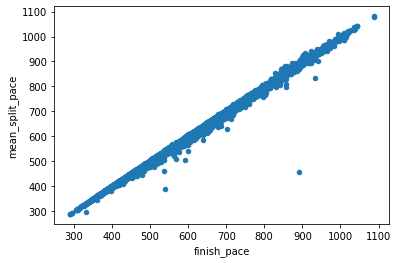

In [202]:
df.plot.scatter(x="finish_pace", y="mean_split_pace")

In [127]:
# easiest / hard split
splits_times = pd.DataFrame(df_similar["5km_split_pace"].array, columns=["5km.split", "10km.split", "15km.split", "20km.split", "25km.split", "30km.split", "35km.split", "40km.split"])
splits_times.describe().astype(int).applymap(seconds_to_time)

,5km.split,10km.split,15km.split,20km.split,25km.split,30km.split,35km.split,40km.split
count,00:41:54,00:41:54,00:41:54,00:41:54,00:41:54,00:41:54,00:41:54,00:41:54
mean,00:08:19,00:08:23,00:08:19,00:08:31,00:08:52,00:09:32,00:10:10,00:10:53
std,00:01:01,00:00:57,00:00:54,00:00:56,00:01:08,00:01:26,00:01:36,00:01:51
min,00:05:50,00:05:57,00:05:53,00:05:48,00:05:50,00:06:36,00:06:42,00:06:53
25%,00:07:33,00:07:40,00:07:39,00:07:47,00:08:00,00:08:26,00:08:53,00:09:30
50%,00:08:20,00:08:25,00:08:21,00:08:33,00:08:48,00:09:24,00:10:03,00:10:47
75%,00:09:01,00:09:02,00:08:58,00:09:10,00:09:38,00:10:33,00:11:16,00:12:06
max,00:16:14,00:11:36,00:13:06,00:13:08,00:14:08,00:21:48,00:21:26,00:23:28


In [137]:
df.sort_values("hit_wall_ratio")

,country,age_class,0km.time,5km.time,10km.time,15km.time,20km.time,half.time,25km.time,30km.time,...,40km.time,finish.time,finish_pace,half_pace,5km_split_pace,mean_split_pace,mean_split_pace_norm,std_split_pace,std_split_pace_norm,hit_wall_ratio
13425,USA,50-54,0,2258.0,4815.0,7413.0,10311.0,10975.0,13546.0,17186.0,...,21941.0,22416,855,837,"[726, 823, 836, 932, 1041, 1171, 1181, 348]",882,0.039347,253,0.286848,0.363040
13882,USA,55-59,0,2453.0,5268.0,8121.0,11398.0,12131.0,14874.0,18350.0,...,23240.0,23747,906,926,"[789, 906, 918, 1054, 1118, 1118, 1201, 372]",934,0.039331,247,0.264454,0.366554
13344,USA,40-44,0,2382.0,5006.0,7728.0,10798.0,11508.0,14158.0,17646.0,...,21737.0,22232,848,878,"[766, 844, 876, 988, 1081, 1122, 954, 362]",874,0.039313,223,0.255149,0.382144
13112,USA,25-29,0,2275.0,4870.0,7484.0,10356.0,11022.0,13399.0,16748.0,...,21251.0,21736,829,841,"[732, 835, 841, 924, 979, 1077, 1093, 356]",854,0.039290,221,0.258782,0.384509
13315,USA,50-54,0,2319.0,4689.0,7209.0,9966.0,10697.0,13172.0,16624.0,...,21590.0,22132,844,816,"[746, 762, 811, 887, 1031, 1111, 1200, 397]",868,0.039219,236,0.271889,0.424404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13209,USA,55-59,0,1706.0,3354.0,4987.0,6745.0,7175.0,8965.0,11555.0,...,20978.0,21934,837,547,"[549, 530, 525, 565, 714, 833, 812, 2220]",843,0.038433,533,0.632266,3.431979
9130,USA,35-39,0,1269.0,2539.0,3812.0,5105.0,5395.0,6574.0,8317.0,...,15575.0,17258,658,411,"[408, 408, 409, 416, 472, 561, 638, 1697]",626,0.036273,412,0.658147,3.586655
11509,USA,30-34,0,1259.0,2610.0,4000.0,5461.0,5798.0,7159.0,9275.0,...,17830.0,19380,739,442,"[405, 434, 447, 470, 546, 681, 705, 2048]",717,0.036997,514,0.716876,3.887202
13338,USA,50-54,0,1875.0,3699.0,5409.0,7198.0,7596.0,9045.0,10991.0,...,20873.0,22212,847,579,"[603, 587, 550, 575, 594, 626, 647, 2533]",839,0.037772,640,0.762813,4.239837


In [ ]:
# todo look for people who were on pace, but failed
# todo look for people who weren't on pace, but succeeded
# did time of day when someone start matter?
# which was easiest / hardest split?
# do people who run even splits do better?
# find runners 


# visualization
# x time, y total distane, plot everyone

In [ ]:
data[0]

In [ ]:
def make_feature(runner):
    features = {
     "age_class": runner["age_class"],   
     "country": runner["country"]
    }
    
    split_times = []
    split_diffs = []
    for split, value in runner["splits"].items():
        if value["time"] == "–":
            split_time = None
        else:
            split_time = time_to_seconds(value["time"])
            
        split_times.append(split_time)
            
        features[split+"_elapsed"] = split_times[-1]

        # todo do something to hand half
        if len(split_times) >= 2 and split_times[-1] and split_times[-2]:
            split_diff = split_times[-1] - split_times[-2]
            features[split+"_diff"] = split_diff
            split_diffs.append(split_diff)
            features[split+"_std"] = pd.Series(split_diffs).std()
            
    return features

df = pd.DataFrame([make_feature(d) for d in tqdm.tqdm(data)])

In [ ]:
df

In [ ]:
df.groupby("age_class")["finish_elapsed"].mean().map(seconds_to_time)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

In [ ]:
select = ["age_class", "5km_elapsed", "10km_elapsed", "10km_diff", "15km_elapsed", "15km_diff", "15km_std", "20km_elapsed", "20km_diff", "20km_std", "25km_elapsed", "25km_diff", "25km_std","finish_elapsed"]
select = [s for s in select if "diff" not in s]
df_select = df[select].fillna(np.nan)
df_select["age_class"] = df_select["age_class"].str[:2].astype(int)
df_select = df_select[['20km_elapsed', "finish_elapsed"]]



In [ ]:
df_select

In [ ]:
df.corr()["finish_elapsed"].sort_values(ascending=False)

In [ ]:
X = df_select.copy()
y = X.pop("finish_elapsed")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
clf = RandomForestClassifier(max_depth=2, n_jobs=-2, random_state=0, verbose=True)

p = make_pipeline(imp, clf)
p.fit(X_train, y_train)

In [ ]:
print("Predict mean time:", mean_absolute_percentage_error(y_test, [y_test.mean()]*len(y_test)))
print("Predict median time:", mean_absolute_percentage_error(y_test, [y_test.median()]*len(y_test)))

In [ ]:
y_pred = p.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

In [ ]:
pd.DataFrame(zip(p.named_steps.randomforestclassifier.feature_importances_, p.feature_names_in_)).sort_values(0, ascending=False)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
p.fit(X_train, y_train)